# Copyright

<PRE>
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Use this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Author classification
The task is to train a 1D CNN or an LSTM that is able to  classify text from two authors. The final model should be able to tell about a text with a given length (e.g. 60 characters) who wrote it.

Please write the codes according to the following parts:

## Python module imports
Import all Python modules that you would need during the Assignment.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk import FreqDist
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import spacy
from spacy import displacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, LSTM, Dense, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
# import en_core_web_sm as en

## Data acquisition
Seek a possible dataset, you can use any source, e.g.
* http://www.gutenberg.org/
* https://www.kaggle.com/datasets
* https://paperswithcode.com/datasets
* if you would like to learn Hungarian, than e.g. https://mek.oszk.hu/

You can download the text by hand (e.g. by copy-pasting some parts into txt files) or with Python.

# Text was downloaded and cleaned by hand from https://www.gutenberg.org/ and saved in the "data" folder

## Data analysis
Count the number of characters from both authors and display them on a plot (e.g. Seaborn's countplot).

<Axes: xlabel='Book', ylabel='Character Count'>

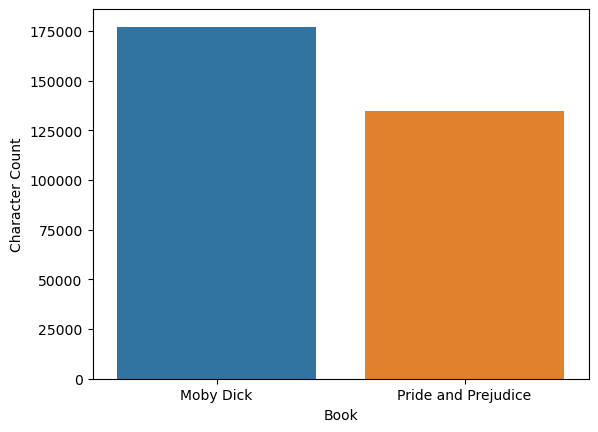

In [2]:
# Read the files
moby_dick_file = "data/moby_dick.txt"
pride_and_prejudice_file = "data/pride_and_prejudice.txt"

with open(moby_dick_file, "r") as file:
    moby_dick_text = file.read()

with open(pride_and_prejudice_file, "r") as file:
    pride_and_prejudice_text = file.read()

# Count the number of characters
moby_dick_count = len(moby_dick_text)
pride_and_prejudice_count = len(pride_and_prejudice_text)

# Create a dataframe
data = pd.DataFrame({'Book': ['Moby Dick', 'Pride and Prejudice'], 'Character Count': [moby_dick_count, pride_and_prejudice_count]})

# Plot the countplot
sns.barplot(x='Book', y='Character Count', data=data)


## Data loading, labeling and preprocessing
Load the data and convert the characters into one-hot encodings. Then load the data into a 3D NumPy array, with a shape of

* (batch, sequence_length, alphabet_length)

where sequence_length=60, and alphabet_length equals to the number of unique characters in both datasets. The sequences should be cut out from the complete dataset by sliding window. You should add 0 and 1 labels to the sequences, according to the author.

Later you may change sequence_length to achieve better results!

In [3]:
# Load the data from the files
moby_dick_file = "data/moby_dick.txt"
pride_and_prejudice_file = "data/pride_and_prejudice.txt"

with open(moby_dick_file, "r") as file:
    moby_dick_text = file.read()

with open(pride_and_prejudice_file, "r") as file:
    pride_and_prejudice_text = file.read()

# Combine the texts
combined_text = moby_dick_text + pride_and_prejudice_text

# Convert to lowercase
combined_text = combined_text.lower()

# Create a set of unique characters
unique_chars = sorted(set(combined_text))

# Create a mapping from characters to indices
char_to_index = {char: index for index, char in enumerate(unique_chars)}

# Determine the number of unique characters
alphabet_length = len(unique_chars)

# Define the sequence length
sequence_length = 60

# Create empty lists for sequences and labels
sequences = []
labels = []

# Generate sequences and labels using sliding window
for i in range(0, len(combined_text) - sequence_length + 1, sequence_length):
    sequence = combined_text[i:i+sequence_length]
    label = 0 if i < len(moby_dick_text) else 1
    sequences.append([char_to_index[char] for char in sequence])
    labels.append(label)

# Convert sequences and labels to NumPy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Convert sequences to one-hot encodings
one_hot_sequences = np.zeros((len(sequences), sequence_length, alphabet_length))
for i, sequence in enumerate(sequences):
    for j, char_index in enumerate(sequence):
        one_hot_sequences[i, j, char_index] = 1

# Print the shape of the one-hot sequences array
print(one_hot_sequences.shape)
print(unique_chars)



(5199, 60, 56)
['\n', ' ', '!', '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '5', '6', '7', '8', '9', ':', ';', '?', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'é', 'œ', '—', '‘', '’', '“', '”']


# Understanding and checking one-hot encoding
A given sequence is converted into numbers by taking each characer and translating it to the corresponding index in the alphabet. Each character is then given its own vector, for which it is one-hot encoded depending on which number it was in the alphabet.

In [4]:
# Initialize a matrix to hold the one-hot encoding
one_hot_encoding = np.zeros((len(sequences[0]), alphabet_length))

# Iterate over each character index in the sequence
for i, char_index in enumerate(sequences[0]):
    # Set the corresponding entry to 1
    one_hot_encoding[i, char_index] = 1

# Compare one_hot_sequences[0] with one_hot_encoding
are_equal = np.array_equal(one_hot_sequences[0], one_hot_encoding)
# Print the result
print("Are equal:", are_equal)


Are equal: True


In [5]:
print(len(moby_dick_text))
print(len(pride_and_prejudice_text))
print(len(combined_text))

177202
134739
311941


## Data splitting
Split the data into train, validate and test sets. Make

In [6]:
# Split the data and labels into train and remaining sets
X_train, X_remaining, Y_train, Y_remaining = train_test_split(one_hot_sequences, labels, test_size=0.4, random_state=42)

# Split the remaining data and labels into test and validation sets
X_test, X_val, Y_test, Y_val = train_test_split(X_remaining, Y_remaining, test_size=0.5, random_state=42)

# Print the shapes of the train, test, and validation sets
print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Validation set shape:", X_val.shape)


Train set shape: (3119, 60, 56)
Test set shape: (1040, 60, 56)
Validation set shape: (1040, 60, 56)


In [115]:
# # Define the proportions for train, test, and validation splits
# train_ratio = 0.6
# test_ratio = 0.2
# val_ratio = 0.2

# # Calculate the number of samples for each split
# num_samples = len(one_hot_sequences)
# num_train = int(train_ratio * num_samples)
# num_test = int(test_ratio * num_samples)
# num_val = num_samples - num_train - num_test

# # Split the one_hot_sequences array into train, test, and validation sets
# X_train = one_hot_sequences[:num_train]
# X_test = one_hot_sequences[num_train:num_train+num_test]
# X_val = one_hot_sequences[num_train+num_test:]

# # Print the shapes of the train, test, and validation sets
# print("Train set shape:", X_train.shape)
# print("Test set shape:", X_test.shape)
# print("Validation set shape:", X_val.shape)

# # Define the proportions for train, test, and validation splits
# train_ratio = 0.6
# test_ratio = 0.2
# val_ratio = 0.2

# # Calculate the number of samples for each split
# num_samples = len(one_hot_sequences)
# num_train = int(train_ratio * num_samples)
# num_test = int(test_ratio * num_samples)
# num_val = num_samples - num_train - num_test

# # Split the labels array into train, test, and validation sets
# Y_train = labels[:num_train]
# Y_test = labels[num_train:num_train+num_test]
# Y_val = labels[num_train+num_test:]

# # Print the shapes of the train, test, and validation sets
# print("Train set shape:", Y_train.shape)
# print("Test set shape:", Y_test.shape)
# print("Validation set shape:", Y_val.shape)



## Model definition
Define a 1D CNN or an LSTM for the task. Compile the model with the correct loss function.

# CNN

In [7]:
# Define the model
model_cnn = Sequential()
model_cnn.add(Conv1D(64, 3, activation='relu', input_shape=(60, 56)))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))
# Compile the model
model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# LSTM

In [8]:
# Define the model
model_lstm = Sequential()
model_lstm.add(LSTM(64, input_shape=(60, 56)))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(1, activation='sigmoid'))

# Compile the model
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


## Model training
Train the model and apply early stopping.

In [9]:
print(model_cnn.summary())
print(model_lstm.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 58, 64)            10816     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 15,041
Trainable params: 15,041
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
 Layer (type)            

In [16]:
# Define the early stopping callback
es = EarlyStopping(patience=10, restore_best_weights=True)
es_lstm = EarlyStopping(patience=40, restore_best_weights=True)


# Train the model
cnn_history = model_cnn.fit(X_train, Y_train,
                            validation_data=(X_val,Y_val),
                            batch_size=32,
                            epochs=100,
                            verbose=1,
                            callbacks=[es])

Epoch 1/100
98/98 [==============================] - 0s 3ms/step - loss: 0.1181 - accuracy: 0.9673 - val_loss: 0.3871 - val_accuracy: 0.8404
Epoch 2/100
98/98 [==============================] - 0s 3ms/step - loss: 0.0949 - accuracy: 0.9727 - val_loss: 0.3542 - val_accuracy: 0.8587
Epoch 3/100
98/98 [==============================] - 0s 2ms/step - loss: 0.0675 - accuracy: 0.9872 - val_loss: 0.3749 - val_accuracy: 0.8500
Epoch 4/100
98/98 [==============================] - 0s 2ms/step - loss: 0.0535 - accuracy: 0.9910 - val_loss: 0.3919 - val_accuracy: 0.8558
Epoch 5/100
98/98 [==============================] - 0s 2ms/step - loss: 0.0442 - accuracy: 0.9942 - val_loss: 0.4064 - val_accuracy: 0.8510
Epoch 6/100
98/98 [==============================] - 0s 2ms/step - loss: 0.0328 - accuracy: 0.9990 - val_loss: 0.4126 - val_accuracy: 0.8567
Epoch 7/100
98/98 [==============================] - 0s 2ms/step - loss: 0.0235 - accuracy: 1.0000 - val_loss: 0.4355 - val_accuracy: 0.8538
Epoch 8/100
9

In [18]:
lstm_history = model_lstm.fit(X_train, Y_train,
                            validation_data=(X_val, Y_val),
                            batch_size=32,
                            epochs=100,
                            verbose=1,
                            callbacks=[es_lstm])


Epoch 1/100
98/98 [==============================] - 1s 15ms/step - loss: 0.3674 - accuracy: 0.8201 - val_loss: 0.5486 - val_accuracy: 0.7337
Epoch 2/100
98/98 [==============================] - 1s 14ms/step - loss: 0.3475 - accuracy: 0.8269 - val_loss: 0.5958 - val_accuracy: 0.7327
Epoch 3/100
98/98 [==============================] - 1s 14ms/step - loss: 0.3473 - accuracy: 0.8317 - val_loss: 0.6074 - val_accuracy: 0.7240
Epoch 4/100
98/98 [==============================] - 1s 14ms/step - loss: 0.3405 - accuracy: 0.8336 - val_loss: 0.5577 - val_accuracy: 0.7308
Epoch 5/100
98/98 [==============================] - 1s 14ms/step - loss: 0.3253 - accuracy: 0.8381 - val_loss: 0.6039 - val_accuracy: 0.7337
Epoch 6/100
98/98 [==============================] - 1s 14ms/step - loss: 0.3559 - accuracy: 0.8259 - val_loss: 0.6212 - val_accuracy: 0.7394
Epoch 7/100
98/98 [==============================] - 1s 14ms/step - loss: 0.3285 - accuracy: 0.8477 - val_loss: 0.6031 - val_accuracy: 0.7462
Epoch 

## Evaluation on test data
Evaluate the model on the test data in terms of loss and accuracy.

In [19]:
# For 1D CNN model
loss, accuracy = model_cnn.evaluate(X_test, Y_test)
print(f'CNN Test Loss: {loss:.4f}, CNN Test Accuracy: {accuracy:.4f}')

# For LSTM model
loss, accuracy = model_lstm.evaluate(X_test, Y_test)
print(f'LSTM Test Loss: {loss:.4f}, LSTM Test Accuracy: {accuracy:.4f}')

33/33 [==============================] - 0s 2ms/step - loss: 0.3949 - accuracy: 0.8519
CNN Test Loss: 0.3949, CNN Test Accuracy: 0.8519
33/33 [==============================] - 0s 4ms/step - loss: 0.6223 - accuracy: 0.7183
LSTM Test Loss: 0.6223, LSTM Test Accuracy: 0.7183


## Confusion matrix
Calculate and display the confusion matrix.

 1/33 [..............................] - ETA: 0s

33/33 [==============================] - 0s 851us/step


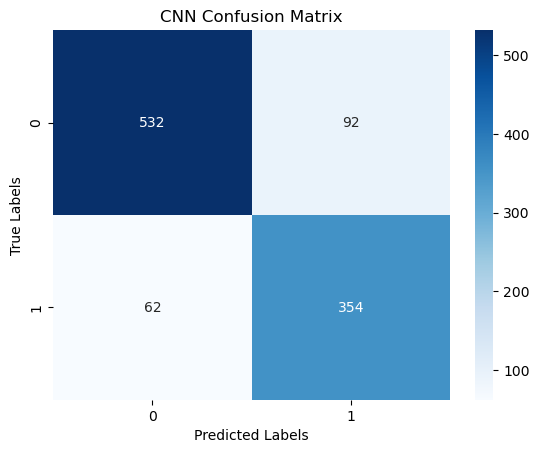

33/33 [==============================] - 0s 4ms/step


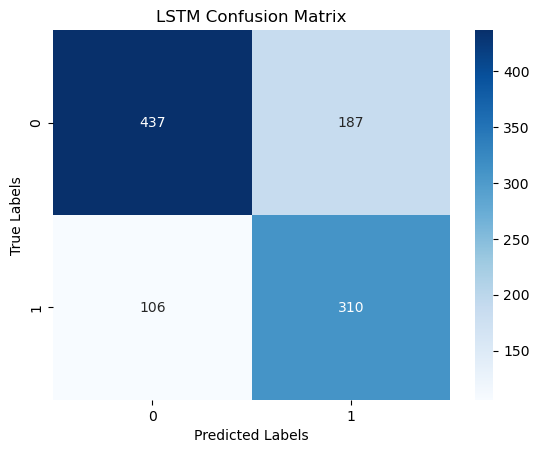

In [20]:
# Define the true labels and predicted labels
true_labels = Y_test

# For 1D CNN model

# Predict the labels
predicted_probabilities = model_cnn.predict(X_test)
predicted_labels = [1 if prob > 0.5 else 0 for prob in predicted_probabilities]

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('CNN Confusion Matrix')
plt.show()

predicted_probabilities = model_lstm.predict(X_test)
predicted_labels = [1 if prob > 0.5 else 0 for prob in predicted_probabilities]

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('LSTM Confusion Matrix')
plt.show()
